In [73]:
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd
from PIL import Image

In [ ]:
def apply_adaptive_threshold(img):
    gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    th_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(th_img)

def apply_clahe_and_threshold(img):
    img_yuv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YUV)
    img_clahe = img_yuv.copy()
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img_clahe[:,:,0] = clahe.apply(img_clahe[:,:,0])
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YUV2BGR)

    return apply_adaptive_threshold(img_clahe)

# 이미지 변환 연결하기
transform = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.Lambda(apply_clahe_and_threshold),  
    transforms.ToTensor()  
])

# 이미지 폴더 데이터셋 불러오기
data = ImageFolder(root="./add_data", transform=transform)  # 데이터를 추가하였음
data2 = ImageFolder(root="./data_test", transform=transform)

In [74]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)
test_loader = DataLoader(data2, batch_size=10, shuffle=True)

In [75]:
images, labels = next(iter(data_loader))
print(images.shape, labels.shape)

torch.Size([10, 1, 50, 50]) torch.Size([10])


In [76]:
class Mob_Dog(nn.Module):
    def __init__(self):
        super(Mob_Dog, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 추가
        self.batchnorm1 = nn.BatchNorm2d(6)  # Batch Normalization 추가
        self.batchnorm2 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.batchnorm3 = nn.BatchNorm1d(120)  # Batch Normalization 추가
        self.batchnorm4 = nn.BatchNorm1d(84)  # Batch Normalization 추가
        
    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Batch Normalization 추가
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.batchnorm3(self.fc1(x)))  # Batch Normalization 추가
        x = F.relu(self.batchnorm4(self.fc2(x)))  # Batch Normalization 추가
        x = self.dropout(x)  # Dropout 추가
        x = self.fc3(x)
        return x


In [77]:
# 모델 객체 생성, 옵티마이저 생성
model = Mob_Dog()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [78]:
def get_accuracy(loader, model):
    total=0
    correct=0
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [79]:
from tqdm import tqdm # 프로그레스 바 생성
from torch.optim.lr_scheduler import ReduceLROnPlateau 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)

loss_list=[]
tas_list=[]
tes_list=[]
max=0
for epoch in range(100): # 10회 반복 
    running_loss = 0.0 # 1 epoch당 누적 로스값 
    #==================================================================================
    pbar = tqdm(enumerate(data_loader), total=len(data_loader)) 
    for i, data in pbar: # pbar가 데이터 로더 역할 수행
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # 로스 누적 
        if i % 10 == 9:
            pbar.set_description(f'Epoch [{epoch + 1}/{10}], 횟수 [{i + 1}/{len(data_loader)}], Loss: {running_loss / 10:.4f}')
            loss_list.append(running_loss)
            running_loss = 0.0
    #==================================================================================   
    # 모델 평가

    with torch.no_grad():
        train_accuracy = get_accuracy(data_loader, model)
        test_accuracy = get_accuracy(test_loader, model)
    print(f'{epoch} Epoch 종료 후 train_score : {(100 * train_accuracy)}')
    print(f'{epoch} Epoch 종료 후 test_score : {(100 * test_accuracy)}')
    tas_list.append(train_accuracy)
    tes_list.append(test_accuracy)
    if max < test_accuracy:
        max = test_accuracy
        torch.save(model, 'model.pth')
        print(f"\n모델 갱신! [[{test_accuracy}]] 저장됌!!!!\n＼북-적／＼북-적／\nʕ•̫͡•ʕ•̫͡•ʔ•̫͡•ʔ•̫͡•ʕ•̫͡•ʔ•̫͡•ʔ")
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early Stopping at : {epoch} Epoch")
        break

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [1/10], 횟수 [40/43], Loss: 0.6720: 100%|██████████| 43/43 [00:01<00:00, 37.28it/s]


0 Epoch 종료 후 train_score : 79.14691943127961
0 Epoch 종료 후 test_score : 59.78260869565217

모델 갱신!(0.5978260869565217저장됌!!!!



Epoch [2/10], 횟수 [40/43], Loss: 0.4339: 100%|██████████| 43/43 [00:01<00:00, 41.57it/s]


1 Epoch 종료 후 train_score : 86.49289099526067
1 Epoch 종료 후 test_score : 59.78260869565217


Epoch [3/10], 횟수 [40/43], Loss: 0.3496: 100%|██████████| 43/43 [00:00<00:00, 43.01it/s]


2 Epoch 종료 후 train_score : 96.2085308056872
2 Epoch 종료 후 test_score : 58.69565217391305


Epoch [4/10], 횟수 [40/43], Loss: 0.1993: 100%|██████████| 43/43 [00:01<00:00, 41.90it/s]


3 Epoch 종료 후 train_score : 97.86729857819904
3 Epoch 종료 후 test_score : 58.69565217391305


Epoch [5/10], 횟수 [40/43], Loss: 0.1016: 100%|██████████| 43/43 [00:01<00:00, 39.19it/s]


4 Epoch 종료 후 train_score : 97.86729857819904
4 Epoch 종료 후 test_score : 67.3913043478261

모델 갱신!(0.6739130434782609저장됌!!!!



Epoch [6/10], 횟수 [40/43], Loss: 0.0911: 100%|██████████| 43/43 [00:01<00:00, 41.65it/s]


5 Epoch 종료 후 train_score : 97.6303317535545
5 Epoch 종료 후 test_score : 71.73913043478261

모델 갱신!(0.717391304347826저장됌!!!!



Epoch [7/10], 횟수 [40/43], Loss: 0.0779: 100%|██████████| 43/43 [00:01<00:00, 41.66it/s]


6 Epoch 종료 후 train_score : 97.86729857819904
6 Epoch 종료 후 test_score : 61.95652173913043


Epoch [8/10], 횟수 [40/43], Loss: 0.0602: 100%|██████████| 43/43 [00:01<00:00, 40.49it/s]


7 Epoch 종료 후 train_score : 97.39336492890996
7 Epoch 종료 후 test_score : 59.78260869565217


Epoch [9/10], 횟수 [40/43], Loss: 0.0711: 100%|██████████| 43/43 [00:01<00:00, 37.28it/s]


8 Epoch 종료 후 train_score : 97.1563981042654
8 Epoch 종료 후 test_score : 58.69565217391305


Epoch [10/10], 횟수 [40/43], Loss: 0.0698: 100%|██████████| 43/43 [00:01<00:00, 41.47it/s]


9 Epoch 종료 후 train_score : 97.86729857819904
9 Epoch 종료 후 test_score : 66.30434782608695


Epoch [11/10], 횟수 [40/43], Loss: 0.3228: 100%|██████████| 43/43 [00:01<00:00, 39.11it/s]


10 Epoch 종료 후 train_score : 97.86729857819904
10 Epoch 종료 후 test_score : 60.86956521739131


Epoch [12/10], 횟수 [40/43], Loss: 0.1923: 100%|██████████| 43/43 [00:01<00:00, 39.28it/s]


11 Epoch 종료 후 train_score : 98.10426540284361
11 Epoch 종료 후 test_score : 59.78260869565217


Epoch [13/10], 횟수 [40/43], Loss: 0.1193: 100%|██████████| 43/43 [00:01<00:00, 41.17it/s]


12 Epoch 종료 후 train_score : 99.0521327014218
12 Epoch 종료 후 test_score : 61.95652173913043


Epoch [14/10], 횟수 [40/43], Loss: 0.0545: 100%|██████████| 43/43 [00:01<00:00, 42.43it/s]


13 Epoch 종료 후 train_score : 96.44549763033176
13 Epoch 종료 후 test_score : 63.04347826086957


Epoch [15/10], 횟수 [40/43], Loss: 0.0641: 100%|██████████| 43/43 [00:01<00:00, 40.96it/s]


14 Epoch 종료 후 train_score : 96.44549763033176
14 Epoch 종료 후 test_score : 67.3913043478261


Epoch [16/10], 횟수 [40/43], Loss: 0.0493: 100%|██████████| 43/43 [00:01<00:00, 37.14it/s]


15 Epoch 종료 후 train_score : 99.0521327014218
15 Epoch 종료 후 test_score : 58.69565217391305


Epoch [17/10], 횟수 [40/43], Loss: 0.2384: 100%|██████████| 43/43 [00:01<00:00, 38.60it/s]


16 Epoch 종료 후 train_score : 97.86729857819904
16 Epoch 종료 후 test_score : 60.86956521739131


Epoch [18/10], 횟수 [40/43], Loss: 0.0419: 100%|██████████| 43/43 [00:01<00:00, 37.32it/s]


17 Epoch 종료 후 train_score : 98.10426540284361
17 Epoch 종료 후 test_score : 69.56521739130434


Epoch [19/10], 횟수 [40/43], Loss: 0.0744: 100%|██████████| 43/43 [00:01<00:00, 38.01it/s]


18 Epoch 종료 후 train_score : 99.28909952606635
18 Epoch 종료 후 test_score : 61.95652173913043


Epoch [20/10], 횟수 [40/43], Loss: 0.0807: 100%|██████████| 43/43 [00:01<00:00, 37.20it/s]


19 Epoch 종료 후 train_score : 99.0521327014218
19 Epoch 종료 후 test_score : 64.13043478260869


Epoch [21/10], 횟수 [40/43], Loss: 0.0330: 100%|██████████| 43/43 [00:01<00:00, 37.32it/s]


20 Epoch 종료 후 train_score : 99.0521327014218
20 Epoch 종료 후 test_score : 57.608695652173914


Epoch [22/10], 횟수 [40/43], Loss: 0.0491: 100%|██████████| 43/43 [00:01<00:00, 36.45it/s]


21 Epoch 종료 후 train_score : 98.81516587677726
21 Epoch 종료 후 test_score : 63.04347826086957


Epoch [23/10], 횟수 [40/43], Loss: 0.0232: 100%|██████████| 43/43 [00:01<00:00, 36.83it/s]


22 Epoch 종료 후 train_score : 97.86729857819904
22 Epoch 종료 후 test_score : 59.78260869565217


Epoch [24/10], 횟수 [40/43], Loss: 0.0423: 100%|██████████| 43/43 [00:01<00:00, 35.72it/s]


23 Epoch 종료 후 train_score : 99.0521327014218
23 Epoch 종료 후 test_score : 60.86956521739131


Epoch [25/10], 횟수 [40/43], Loss: 0.0323: 100%|██████████| 43/43 [00:01<00:00, 37.23it/s]


24 Epoch 종료 후 train_score : 98.5781990521327
24 Epoch 종료 후 test_score : 65.21739130434783


Epoch [26/10], 횟수 [40/43], Loss: 0.2339: 100%|██████████| 43/43 [00:01<00:00, 37.24it/s]


25 Epoch 종료 후 train_score : 93.8388625592417
25 Epoch 종료 후 test_score : 59.78260869565217


Epoch [27/10], 횟수 [40/43], Loss: 0.2354: 100%|██████████| 43/43 [00:01<00:00, 36.98it/s]


26 Epoch 종료 후 train_score : 97.1563981042654
26 Epoch 종료 후 test_score : 56.52173913043478


Epoch [28/10], 횟수 [40/43], Loss: 0.0345: 100%|██████████| 43/43 [00:01<00:00, 36.92it/s]


27 Epoch 종료 후 train_score : 98.10426540284361
27 Epoch 종료 후 test_score : 59.78260869565217


Epoch [29/10], 횟수 [40/43], Loss: 0.0667: 100%|██████████| 43/43 [00:01<00:00, 36.88it/s]


28 Epoch 종료 후 train_score : 98.34123222748815
28 Epoch 종료 후 test_score : 54.347826086956516


Epoch [30/10], 횟수 [40/43], Loss: 0.1021: 100%|██████████| 43/43 [00:01<00:00, 37.07it/s]


29 Epoch 종료 후 train_score : 97.86729857819904
29 Epoch 종료 후 test_score : 64.13043478260869


Epoch [31/10], 횟수 [40/43], Loss: 0.0331: 100%|██████████| 43/43 [00:01<00:00, 35.15it/s]


30 Epoch 종료 후 train_score : 99.0521327014218
30 Epoch 종료 후 test_score : 61.95652173913043


Epoch [32/10], 횟수 [40/43], Loss: 0.0583: 100%|██████████| 43/43 [00:01<00:00, 36.99it/s]


31 Epoch 종료 후 train_score : 99.0521327014218
31 Epoch 종료 후 test_score : 67.3913043478261


Epoch [33/10], 횟수 [40/43], Loss: 0.0544: 100%|██████████| 43/43 [00:01<00:00, 37.09it/s]


32 Epoch 종료 후 train_score : 98.10426540284361
32 Epoch 종료 후 test_score : 61.95652173913043


Epoch [34/10], 횟수 [40/43], Loss: 0.0214: 100%|██████████| 43/43 [00:01<00:00, 36.56it/s]


33 Epoch 종료 후 train_score : 98.81516587677726
33 Epoch 종료 후 test_score : 65.21739130434783


Epoch [35/10], 횟수 [40/43], Loss: 0.0323: 100%|██████████| 43/43 [00:01<00:00, 36.46it/s]


34 Epoch 종료 후 train_score : 98.10426540284361
34 Epoch 종료 후 test_score : 65.21739130434783


Epoch [36/10], 횟수 [40/43], Loss: 0.0724: 100%|██████████| 43/43 [00:01<00:00, 36.93it/s]


35 Epoch 종료 후 train_score : 98.34123222748815
35 Epoch 종료 후 test_score : 59.78260869565217


Epoch [37/10], 횟수 [40/43], Loss: 0.0258: 100%|██████████| 43/43 [00:01<00:00, 37.37it/s]


36 Epoch 종료 후 train_score : 99.0521327014218
36 Epoch 종료 후 test_score : 63.04347826086957


Epoch [38/10], 횟수 [40/43], Loss: 0.0166: 100%|██████████| 43/43 [00:01<00:00, 35.64it/s]


37 Epoch 종료 후 train_score : 98.5781990521327
37 Epoch 종료 후 test_score : 65.21739130434783


Epoch [39/10], 횟수 [40/43], Loss: 0.0153: 100%|██████████| 43/43 [00:01<00:00, 37.21it/s]


38 Epoch 종료 후 train_score : 96.2085308056872
38 Epoch 종료 후 test_score : 68.47826086956522


Epoch [40/10], 횟수 [40/43], Loss: 0.0271: 100%|██████████| 43/43 [00:01<00:00, 37.36it/s]


39 Epoch 종료 후 train_score : 98.5781990521327
39 Epoch 종료 후 test_score : 66.30434782608695


Epoch [41/10], 횟수 [40/43], Loss: 0.0414: 100%|██████████| 43/43 [00:01<00:00, 36.75it/s]


40 Epoch 종료 후 train_score : 98.10426540284361
40 Epoch 종료 후 test_score : 63.04347826086957


Epoch [42/10], 횟수 [40/43], Loss: 0.0320: 100%|██████████| 43/43 [00:01<00:00, 37.05it/s]


41 Epoch 종료 후 train_score : 99.52606635071089
41 Epoch 종료 후 test_score : 67.3913043478261


Epoch [43/10], 횟수 [40/43], Loss: 0.0133: 100%|██████████| 43/43 [00:01<00:00, 37.08it/s]


42 Epoch 종료 후 train_score : 99.0521327014218
42 Epoch 종료 후 test_score : 64.13043478260869


Epoch [44/10], 횟수 [40/43], Loss: 0.0354: 100%|██████████| 43/43 [00:01<00:00, 37.07it/s]


43 Epoch 종료 후 train_score : 99.0521327014218
43 Epoch 종료 후 test_score : 64.13043478260869


Epoch [45/10], 횟수 [40/43], Loss: 0.0286: 100%|██████████| 43/43 [00:01<00:00, 35.72it/s]


44 Epoch 종료 후 train_score : 98.5781990521327
44 Epoch 종료 후 test_score : 65.21739130434783


Epoch [46/10], 횟수 [40/43], Loss: 0.0170: 100%|██████████| 43/43 [00:01<00:00, 36.38it/s]


45 Epoch 종료 후 train_score : 98.81516587677726
45 Epoch 종료 후 test_score : 75.0

모델 갱신!(0.75저장됌!!!!



Epoch [47/10], 횟수 [40/43], Loss: 0.0671: 100%|██████████| 43/43 [00:01<00:00, 36.44it/s]


46 Epoch 종료 후 train_score : 98.81516587677726
46 Epoch 종료 후 test_score : 63.04347826086957


Epoch [48/10], 횟수 [40/43], Loss: 0.0903: 100%|██████████| 43/43 [00:01<00:00, 37.10it/s]


47 Epoch 종료 후 train_score : 95.97156398104265
47 Epoch 종료 후 test_score : 58.69565217391305


Epoch [49/10], 횟수 [40/43], Loss: 0.0247: 100%|██████████| 43/43 [00:01<00:00, 36.45it/s]


48 Epoch 종료 후 train_score : 97.86729857819904
48 Epoch 종료 후 test_score : 57.608695652173914


Epoch [50/10], 횟수 [40/43], Loss: 0.0146: 100%|██████████| 43/43 [00:01<00:00, 35.68it/s]


49 Epoch 종료 후 train_score : 98.34123222748815
49 Epoch 종료 후 test_score : 60.86956521739131


Epoch [51/10], 횟수 [40/43], Loss: 0.0626: 100%|██████████| 43/43 [00:01<00:00, 36.91it/s]


50 Epoch 종료 후 train_score : 99.28909952606635
50 Epoch 종료 후 test_score : 66.30434782608695


Epoch [52/10], 횟수 [40/43], Loss: 0.0063: 100%|██████████| 43/43 [00:01<00:00, 36.90it/s]


51 Epoch 종료 후 train_score : 99.52606635071089
51 Epoch 종료 후 test_score : 58.69565217391305


Epoch [53/10], 횟수 [40/43], Loss: 0.0228: 100%|██████████| 43/43 [00:01<00:00, 37.25it/s]


52 Epoch 종료 후 train_score : 98.10426540284361
52 Epoch 종료 후 test_score : 60.86956521739131


Epoch [54/10], 횟수 [40/43], Loss: 0.0765: 100%|██████████| 43/43 [00:01<00:00, 36.81it/s]


53 Epoch 종료 후 train_score : 97.6303317535545
53 Epoch 종료 후 test_score : 63.04347826086957


Epoch [55/10], 횟수 [40/43], Loss: 0.0418: 100%|██████████| 43/43 [00:01<00:00, 36.65it/s]


54 Epoch 종료 후 train_score : 98.34123222748815
54 Epoch 종료 후 test_score : 67.3913043478261


Epoch [56/10], 횟수 [40/43], Loss: 0.0210: 100%|██████████| 43/43 [00:01<00:00, 35.30it/s]


55 Epoch 종료 후 train_score : 99.0521327014218
55 Epoch 종료 후 test_score : 59.78260869565217


Epoch [57/10], 횟수 [40/43], Loss: 0.0440: 100%|██████████| 43/43 [00:01<00:00, 36.77it/s]


56 Epoch 종료 후 train_score : 99.28909952606635
56 Epoch 종료 후 test_score : 61.95652173913043


Epoch [58/10], 횟수 [40/43], Loss: 0.0976: 100%|██████████| 43/43 [00:01<00:00, 37.29it/s]


57 Epoch 종료 후 train_score : 97.6303317535545
57 Epoch 종료 후 test_score : 66.30434782608695


Epoch [59/10], 횟수 [40/43], Loss: 0.0295: 100%|██████████| 43/43 [00:01<00:00, 37.33it/s]


58 Epoch 종료 후 train_score : 100.0
58 Epoch 종료 후 test_score : 69.56521739130434
Early Stopping at : 58 Epoch


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

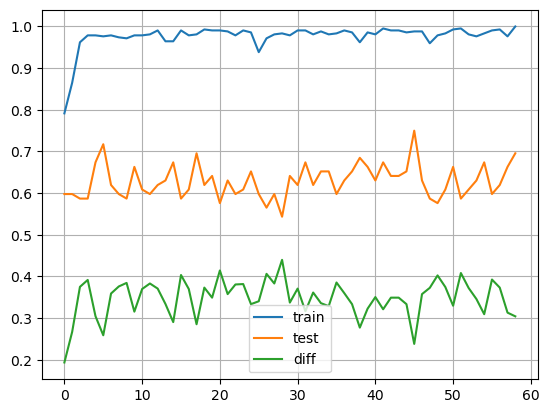

In [84]:
import matplotlib.pyplot as plt

#plt.plot(loss_list)
plt.plot(tas_list, label="train")
plt.plot(tes_list, label="test")
plt.plot(np.array(tas_list)-np.array(tes_list), label="diff")
plt.grid(True)
plt.legend()
plt.ylabel

In [81]:
# 확실히 높아진 성능을 자랑한다....

In [136]:
from torchvision.transforms.functional import to_pil_image
model = Mob_Dog()
model = torch.load('model.pth')
model.eval()

train_accuracy = get_accuracy(data_loader, model) # 모델 검증 
test_accuracy = get_accuracy(test_loader, model)
print(f"train_acc : {train_accuracy:.2f}, test_acc : {test_accuracy:.2f}")


for i in np.array(data2.imgs)[:, 0]:
    img = cv2.imread(i)
    img_pil = to_pil_image(img)  # PIL 이미지로 변환
    
    transformed_img = transform(img_pil)  # 변환 적용
    transformed_img = transformed_img.unsqueeze(0)  # 배치 차원 추가
    
    with torch.no_grad():
        output = model(transformed_img)
        _, predicted = torch.max(torch.softmax(output, dim=1).data, 1)
        print(f"{torch.softmax(output, dim=1).data[0][predicted].item():.2f} 확률로 {'강쥐!!!' if predicted.item() else '부직포'}입니다!")


train_acc : 1.00, test_acc : 0.70
1.00 확률로 강쥐!!!입니다!
0.93 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.93 확률로 부직포입니다!
0.89 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.99 확률로 부직포입니다!
0.75 확률로 강쥐!!!입니다!
0.86 확률로 강쥐!!!입니다!
1.00 확률로 부직포입니다!
0.85 확률로 부직포입니다!
1.00 확률로 부직포입니다!
1.00 확률로 강쥐!!!입니다!
0.94 확률로 강쥐!!!입니다!
0.92 확률로 강쥐!!!입니다!
1.00 확률로 부직포입니다!
0.70 확률로 부직포입니다!
0.99 확률로 강쥐!!!입니다!
0.85 확률로 부직포입니다!
0.84 확률로 강쥐!!!입니다!
1.00 확률로 부직포입니다!
1.00 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.96 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.67 확률로 부직포입니다!
0.80 확률로 강쥐!!!입니다!
0.86 확률로 부직포입니다!
0.99 확률로 부직포입니다!
0.54 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.81 확률로 부직포입니다!
0.56 확률로 부직포입니다!
1.00 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.95 확률로 강쥐!!!입니다!
1.00 확률로 부직포입니다!
0.70 확률로 부직포입니다!
0.97 확률로 부직포입니다!
1.00 확률로 강쥐!!!입니다!
0.97 확률로 강쥐!!!입니다!
0.87 확률로 강쥐!!!입니다!
0.98 확률로 강쥐!!!입니다!
1.00 확률로 강쥐!!!입니다!
0.99 확률로 부직포입니다!
1.00 확률로 강쥐!!!입니다!
0.99 확률로 강쥐!!!입니다!
0.82 확률로 강쥐!!!입니다!
0.86 확률로 부직포입니다!
0.93 확률로 강쥐!!!입니다!
1.00 확률로 강쥐!!!입니다!
0.60 확률로 부직포입니다!
1.00 확률로 부직포입니다!
0.59 확률로 강쥐!!!입니다!
1.00 확

In [83]:
# 어느정도 만족한다....사람눈으로 봐도 구별하기 좀 힘들어보인다!
# 이제 예측 모델을 만들어보자! 